## Loading of Miller ECoG data of motor imagery

includes some visualizations

In [ ]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 9.6 MB 15.2 MB/s 
     |████████████████████████████████| 13.3 MB 15.7 MB/s 
     |████████████████████████████████| 3.2 MB 56.3 MB/s 
     |████████████████████████████████| 77 kB 8.2 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 179 kB 42.5 MB/s 


In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [ ]:
# @title Preprocess data (`form_data(alldat)`)

def form_data(alldat):

  """

  """

  Ba_bins = np.zeros((7, 2, 60, 52))
  array = np.zeros((7, 2, 60, 52, 3000))
  cues = np.zeros((7, 2, 60))

  for s, rvi, tr in np.ndindex((7, 2, 60)):

    for e in range(alldat[s][rvi]['V'].shape[1]):
      Ba = alldat[s][rvi]['Brodmann_Area'][e]
      Ba = int(Ba[13:])
      t_on = alldat[s][rvi]['t_on']
      t_off = alldat[s][rvi]['t_off']
      movtype = alldat[s][rvi]['stim_id'][tr]

      Vz_t = alldat[s][rvi]['V'][t_on[tr]:t_off[tr], e]
      uV_coeff = alldat[s][rvi]['scale_uv'][e]
      
      array[s][rvi][tr][Ba-1] += uV_coeff * Vz_t
      Ba_bins[s][rvi][tr][Ba-1] += 1
      cues[s][rvi][tr] = movtype
    
    for Ba in range(52):
      if Ba_bins[s][rvi][tr][Ba] != 0:
        array[s][rvi][tr][Ba] /= Ba_bins[s][rvi][tr][Ba]

  return (array, cues, Ba_bins)

In [ ]:
# Preprocessing data
array, cues, Ba_bins = form_data(alldat)

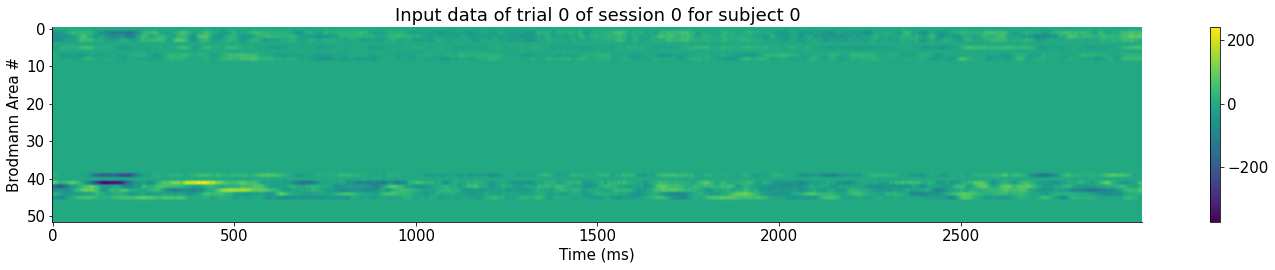

In [ ]:
# Ploting data example
plt.imshow(array[0][0][0], aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Brodmann Area #')
plt.title('Input data of trial 0 of session 0 for subject 0')
plt.colorbar()

(7, 2, 60, 52, 3000)


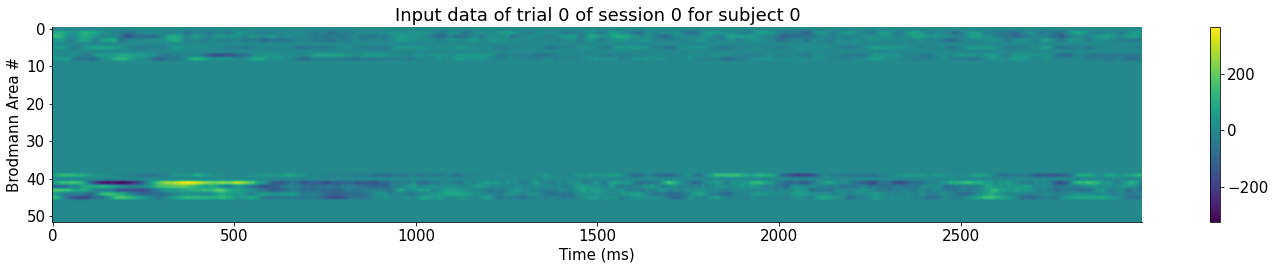

In [ ]:
# @title Data sorting (`sort_by_trial_type(array, cues)`)

# sort trials by cue type

def sort_by_trial_type(array, cues):
  '''

  '''

  sortarray = np.zeros_like(array)
  idx = np.zeros((7, 2))

  for s, rvi, tr in np.ndindex((7, 2, 60)):
    if cues[s][rvi][tr] == 11:
      sortarray[s][rvi][int(idx[s][rvi])] = array[s][rvi][tr]
      idx[s][rvi] += 1

  for s, rvi, tr in np.ndindex((7, 2, 60)):
    if cues[s][rvi][tr] == 12:
      sortarray[s][rvi][int(idx[s][rvi])] = array[s][rvi][tr]
      idx[s][rvi] += 1

  print(sortarray.shape)

  return sortarray

plt.imshow(sort_by_trial_type(array, cues)[0][0][0], aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Brodmann Area #')
plt.title('Input data of trial 0 of session 0 for subject 0')
plt.colorbar()

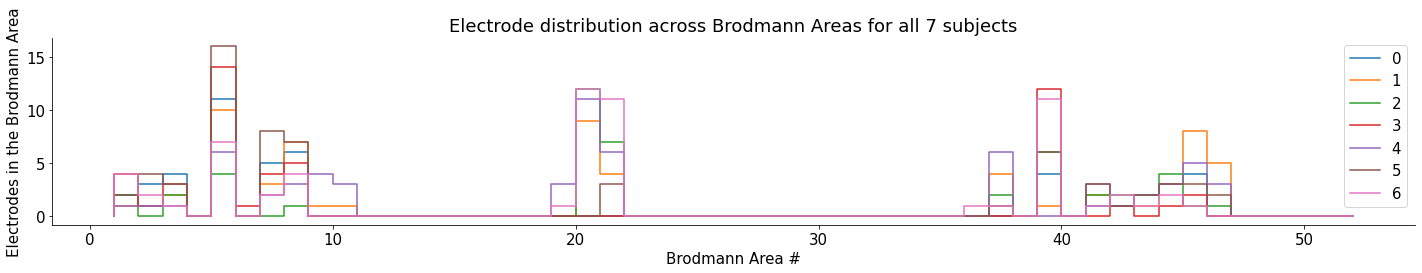

In [ ]:
# Electrode distribution across Broadmann areas

for subj in range(7):
  plt.step(np.arange(1, 53, 1), Ba_bins[subj][0][0], label=subj)
plt.xlabel('Brodmann Area #')
plt.ylabel('Electrodes in the Brodmann Area')
plt.title('Electrode distribution across Brodmann Areas for all 7 subjects')
plt.legend()

In [ ]:
original_Ba_bins = np.sum(Ba_bins, axis=0)[0][0]
original_Ba_bins = original_Ba_bins > 0
original_Ba_bins

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False])

In [ ]:
# Clear unnecessary Brodmann areas
N = np.sum(original_Ba_bins)
print('Total brain areas used N =', N)

def only_nec_Bas(array):
  array_ = np.zeros((7, 2, 60, N, 3000))
  Ba_dict = [0]*N
  i = 0

  for Ba in range(52):
    if original_Ba_bins[Ba]:
      array_[:, :, :, i, :] = array[:, :, :, Ba, :]
      Ba_dict[i] = str(int(Ba+1))
      i+=1
  
  print('Processed array shape:', array_.shape)

  return array_, Ba_dict

Total brain areas used N = 21


(7, 2, 60, 52, 3000)
Processed array shape: (7, 2, 60, 21, 3000)


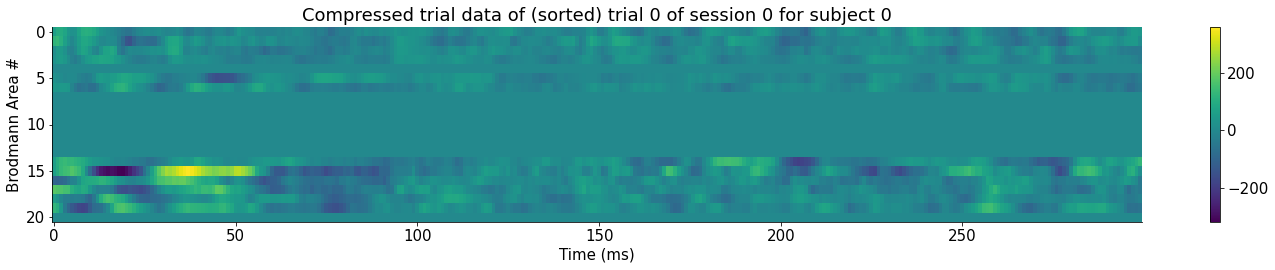

In [ ]:
# Sorting array trials: Real Tounge, Real Hand, Imagery Tounge, Imagery Hand
array_sorted = sort_by_trial_type(array, cues)

# Clearing empty Brodmann areas, leaving only the 21 
data, Ba_dict = only_nec_Bas(array_sorted)

# Creating 'compressed' V(t)s: (3000,) --> (300,), average over time
data_compressed = np.zeros((7, 2, 60, N, 300))

for t in range(300):
  data_compressed[:, :, :, :, t] = np.mean(data[:, :, :, :, 10*t:10*t+10], axis=4)

plt.imshow(data_compressed[0][0][0], aspect='auto')
plt.xlabel('Time (ms)')
plt.ylabel('Brodmann Area #')
plt.title('Compressed trial data of (sorted) trial 0 of session 0 for subject 0')
plt.colorbar()

plt.show()

In [ ]:
plt.figure(figsize=(32, 8))
print('Hand/Tounge ratio os each session')
for s, rvi in np.ndindex((7, 2)):
  #plt.subplot(2, 7, s*2 + rvi + 1)
  #plt.step(np.arange(0, 60, 1), cues[s][rvi])
  print(f'Subject {s}, session {rvi}: {np.mean(cues[s][rvi])-11}')
#plt.show()

Hand/Tounge ratio os each session
Subject 0, session 0: 0.5
Subject 0, session 1: 0.5
Subject 1, session 0: 0.5
Subject 1, session 1: 0.5
Subject 2, session 0: 0.5
Subject 2, session 1: 0.5
Subject 3, session 0: 0.5
Subject 3, session 1: 0.5
Subject 4, session 0: 0.5
Subject 4, session 1: 0.5
Subject 5, session 0: 0.5
Subject 5, session 1: 0.5
Subject 6, session 0: 0.5
Subject 6, session 1: 0.5


<Figure size 2304x576 with 0 Axes>

(7, 360000, 21)


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


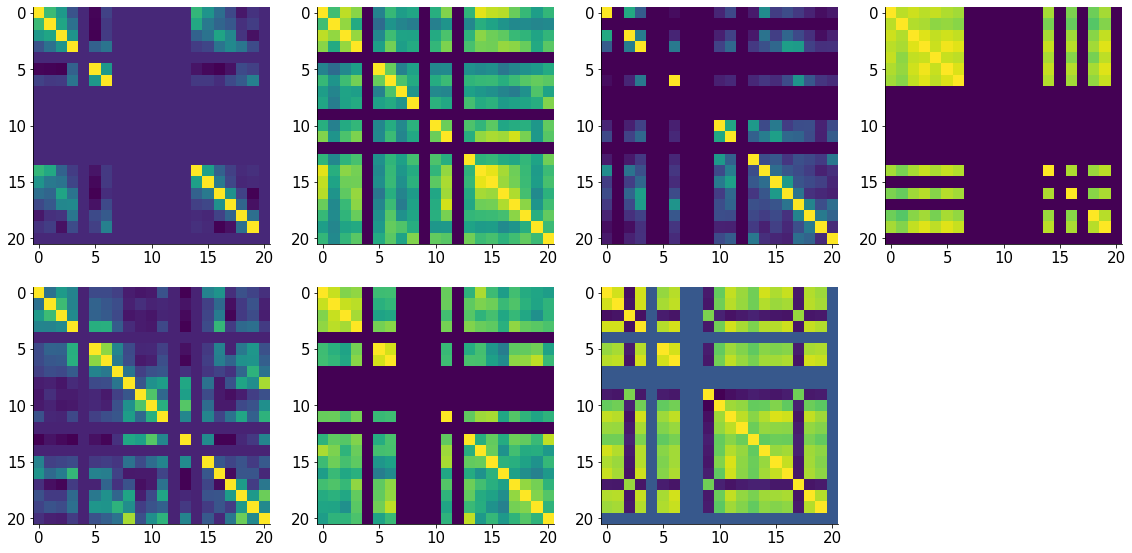

In [ ]:
flatarray = np.zeros((7, 2*60*3000, N))

for s in range(7):
  flatarray[s] = np.vstack([data[s][rvi][tr][:, t] for rvi, tr, t in np.ndindex((2, 60, 3000))])
print(flatarray.shape)

corr = []

plt.figure(figsize=(16, 8))
for s in range(7):
  plt.subplot(2, 4, s+1)
  corr.append(np.corrcoef(flatarray[s].T))
  plt.imshow(np.nan_to_num(corr[-1]))

plt.show()

In [ ]:
#@title Default title text
def mymean(stack):
  """
   Returns mean avoiding 0s.

   Input:
    stack (ndarray): an array of N matrices sized AxB.

   Returns:
    mean (ndarray): a matrix (sized AxB) containing
    the corresponding means.
  """
  N, A, B = stack.shape

  bins = np.zeros_like(stack[0])

  mean = np.sum(stack, axis=0)
  for i in range(N):
    bins += (stack[i]).astype('int')

  mean /= bins

  return mean

In [ ]:
# @title Plotting correlations for all subjects and trial types

def plot_corrs_RITH(corr, subtract=False):
  num = np.array([[[1,  2], [15, 16]], 
                [[3,   4], [17, 18]], 
                [[5,   6], [19, 20]], 
                [[7,   8], [21, 22]], 
                [[9,  10], [23, 24]], 
                [[11, 12], [25, 26]], 
                [[13, 14], [27, 28]]])

  plt.figure(figsize=(14*4, 2*4))
  for s, rvi, tp in np.ndindex((7, 2, 2)):
    ax = plt.subplot(2, 14, num[s][rvi][tp])

    if rvi == 0:
      rvi_str = 'Real'
    else:
      rvi_str = 'Imagery'
    if tp == 0:
      tp_str = 'Tounge'
    else:
      tp_str = 'Hand'

    plt.title('Subject: ' + str(s) + ' ' + rvi_str + ' / ' + tp_str)
    ax.set_xticks(np.arange(0, 21, 1))
    ax.set_yticks(np.arange(0, 21, 1))
    ax.set_xticklabels(Ba_dict, size=7)
    ax.set_yticklabels(Ba_dict, size=7)
    avg = np.nanmean(corr, axis = (1, 2))[s] * int(subtract)
    ax.imshow(np.nan_to_num(corr[s][rvi][tp]-avg))
    #plt.colorbar(y)

  #plt.colorbar(ax)
  plt.show()

In [ ]:
# @title Plotting correlations for all subjects and real/imagery sessions

def plot_corrs_RI(corr):

  plt.figure(figsize=(14*4, 2*4))
  for s, rvi in np.ndindex((7, 2)):
    ax = plt.subplot(2, 7, s + rvi*7 + 1)

    if rvi == 0:
      rvi_str = 'Real'
    else:
      rvi_str = 'Imagery'

    plt.title('Subject: ' + str(s) + ' ' + rvi_str)
    ax.set_xticks(np.arange(0, 21, 1))
    ax.set_yticks(np.arange(0, 21, 1))
    ax.set_xticklabels(Ba_dict, size=7)
    ax.set_yticklabels(Ba_dict, size=7)
    ax.imshow(np.mean(corr, axis=2)[s][rvi])

  plt.show()

In [ ]:
# @title Plotting correlations for all subjects and tounge/hand cue types

def plot_corrs_TH(corr):

  plt.figure(figsize=(14*4, 2*4))
  for s, tp in np.ndindex((7, 2)):
    ax = plt.subplot(1, 14, s*2 + tp + 1)

    if tp == 0:
      tp_str = 'Tounge'
    else:
      tp_str = 'Hand'

    plt.title('Subject: ' + str(s) + ' / ' + tp_str)
    ax.set_xticks(np.arange(0, 21, 1))
    ax.set_yticks(np.arange(0, 21, 1))
    ax.set_xticklabels(Ba_dict, size=7)
    ax.set_yticklabels(Ba_dict, size=7)
    ax.imshow(np.mean(corr, axis = 1)[s][tp])

  plt.show()

In [ ]:
# @title Plotting correlations for real/imagery sessions and tounge/hand cue types

def plot_avgcorrs_RITH(corr):

  plt.figure(figsize=(2*4, 2*4))
  for rvi, tp in np.ndindex((2, 2)):
    ax = plt.subplot(2, 2, 2*rvi + tp + 1)

    if rvi == 0:
      rvi_str = 'Real'
    else:
      rvi_str = 'Imagery'
    if tp == 0:
      tp_str = 'Tounge'
    else:
      tp_str = 'Hand'

    plt.title(rvi_str + ' / ' + tp_str)
    ax.set_xticks(np.arange(0, 21, 1))
    ax.set_yticks(np.arange(0, 21, 1))
    ax.set_xticklabels(Ba_dict, size=7)
    ax.set_yticklabels(Ba_dict, size=7)
    ax.set_xlabel('Brodmann area #')
    ax.set_ylabel('Brodmann area #')
    #avg = np.nanmean(corr, axis = (0, 1, 2))
    print(np.nanmean(corr, axis = 0).shape)
    ax.imshow(np.nan_to_num(np.nanmean(corr, axis = 0)[rvi][tp]))

  plt.show()

In [ ]:
corr = np.zeros((7, 2, 2, N, N))

for s, rvi, tp in np.ndindex((7, 2, 2)):
  corr[s][rvi][tp] = np.corrcoef(flatarray[s][90000*(rvi*2 + tp) : 90000*(rvi*2 + tp + 1)].T)

print(corr.shape)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(7, 2, 2, 21, 21)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


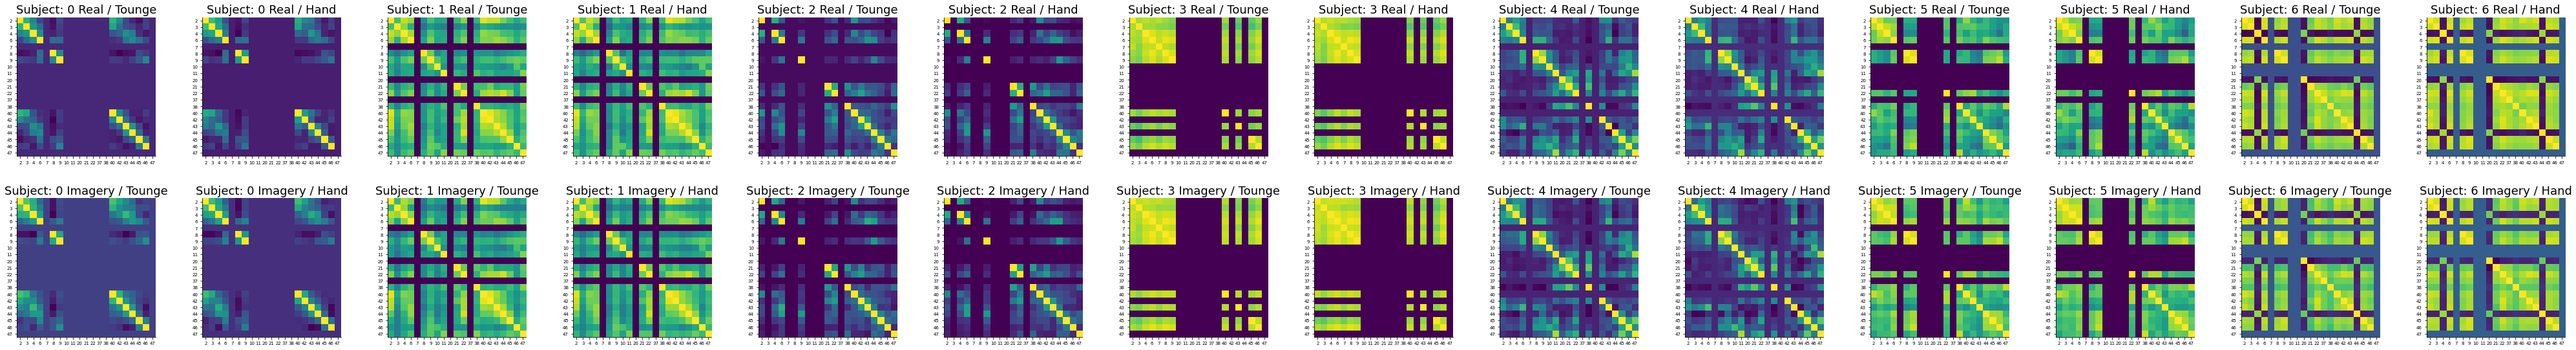

In [ ]:
plot_corrs_RITH(corr)

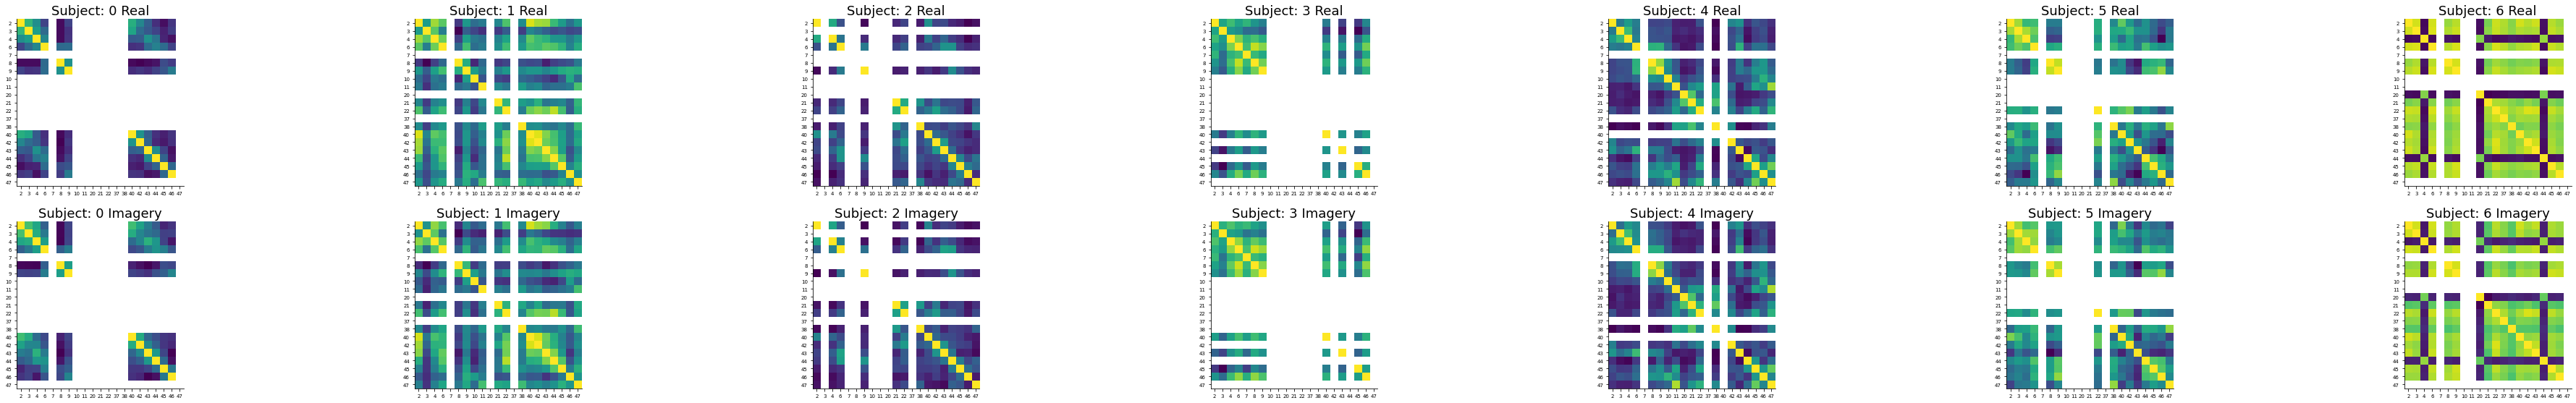

In [ ]:
plot_corrs_RI(corr)

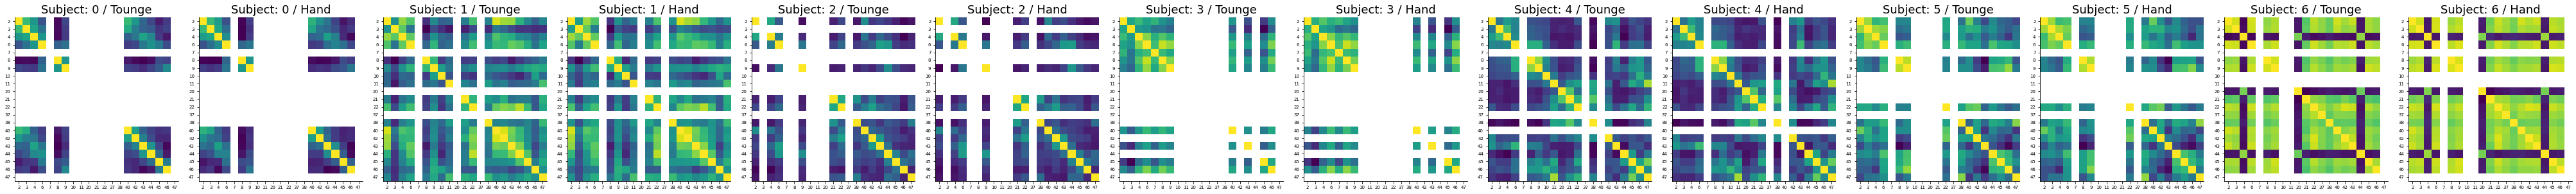

In [ ]:
plot_corrs_TH(corr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


(2, 2, 21, 21)
(2, 2, 21, 21)
(2, 2, 21, 21)
(2, 2, 21, 21)


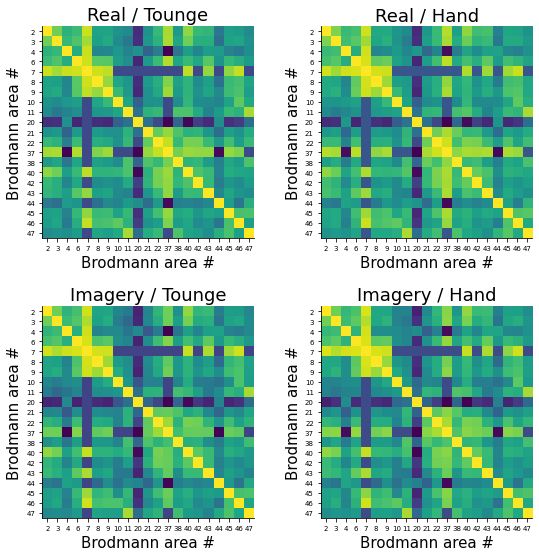

In [ ]:
plot_avgcorrs_RITH(corr)

In [ ]:
def distr_corr(corr_for_pval):
  """
  Discr

  Input:
    corr_for_pval (ndarray): S x RvI x Tp x Tr x N x N

  Output:
    corr_mean
    corr_std (ndarray): S x RvI x Tp x N x N

  """
  corr_mean = np.zeros((7, 2, 2, 21, 21))
  corr_std = np.zeros((7, 2, 2, 21, 21))

  corr_mean = np.nanmean(corr_for_pval, axis = 3)
  corr_std = np.nanstd(corr_for_pval, axis = 3)

  return corr_mean, corr_std

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(7, 2, 2, 30, 21, 21)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


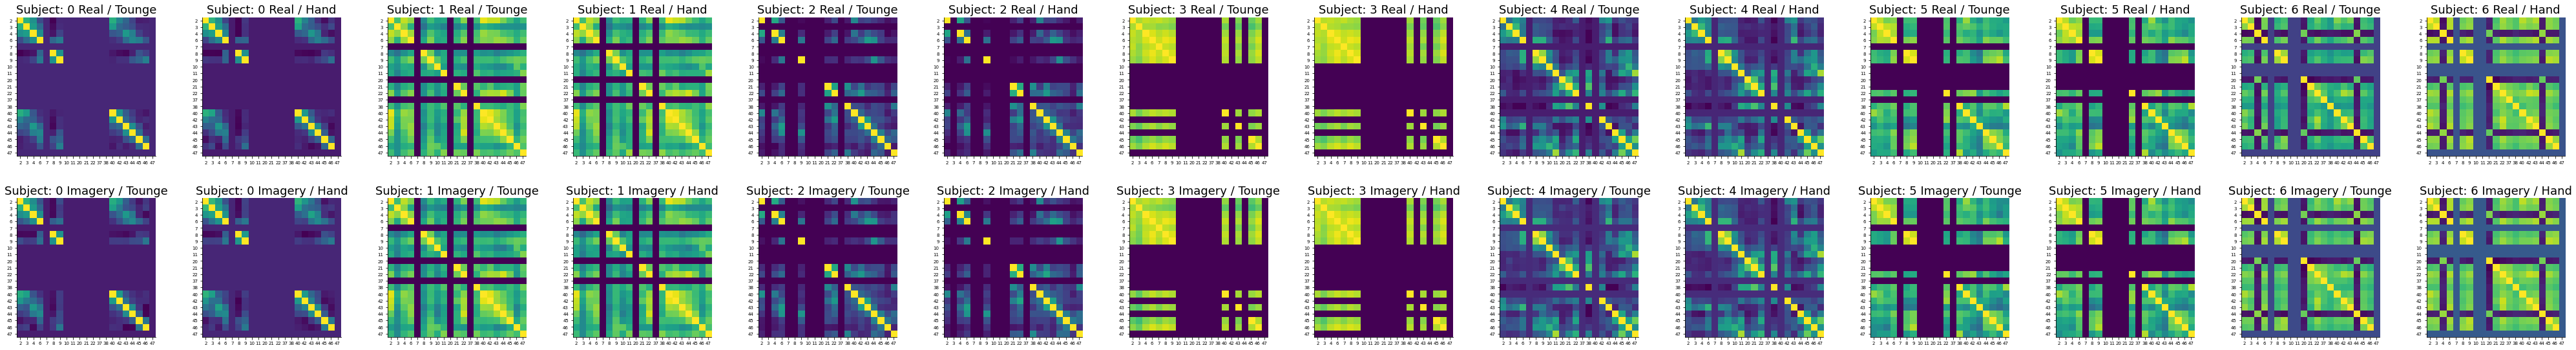

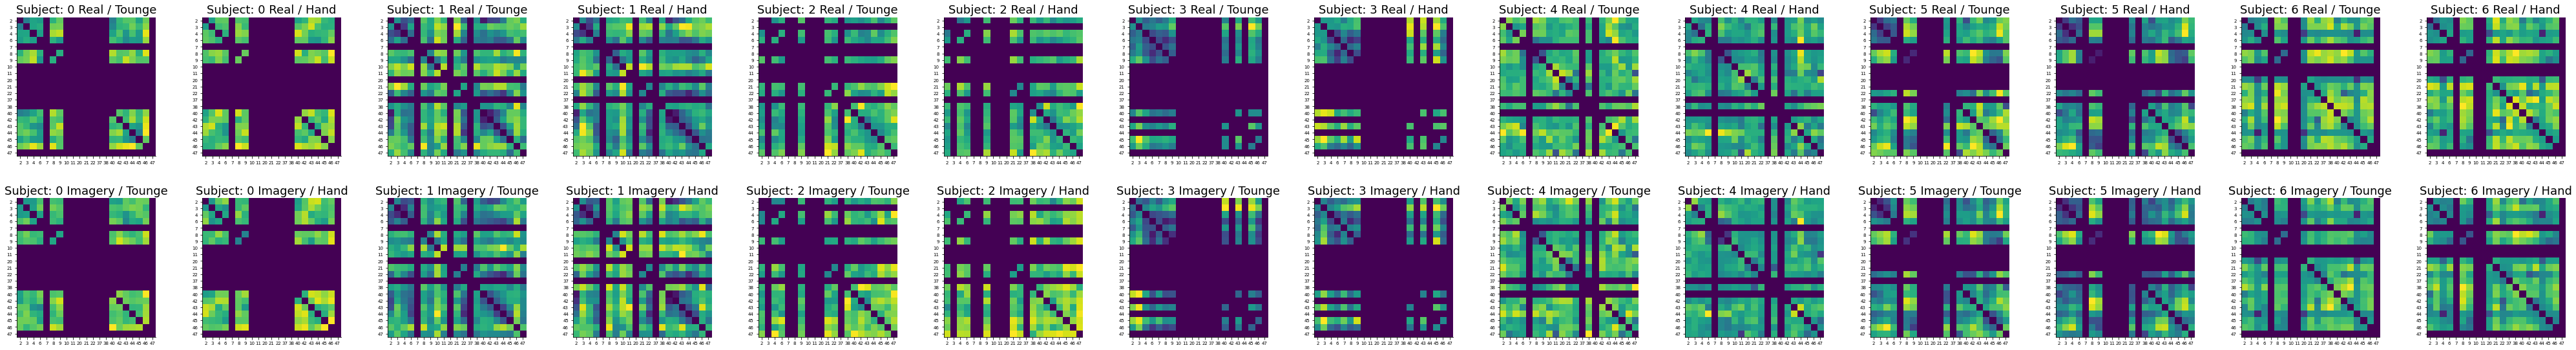

In [ ]:
corr_for_pval_ = np.zeros((7, 2, 2, 30, N, N))

for s, rvi, tp, tr in np.ndindex((7, 2, 2, 30)):
  corr_for_pval_[s][rvi][tp][tr] = np.corrcoef(flatarray[s][3000*(tr*2*2 + rvi*2 + tp) : 3000*(tr*2*2 + rvi*2 + tp + 1)].T)
print(corr_for_pval_.shape)

# Let's flatten it!
#corr_for_pval__ = np.zeros((7, 2, 2, 30, N*N))
#for s, rvi, tp, tr in np.ndindex((7, 2, 2, 30)):
#  corr_for_pval__[s][rvi][tp][tr] = np.hstack(corr_for_pval_[s, rvi, tp, tr, Ba] for Ba in range(N))
#print(corr_for_pval__.shape)
# for s, rvi, tp in np.ndindex((7, 2, 2))])
#print(corr_for_pval_.shape)
#plt.imshow(np.nan_to_num(corr_for_pval), aspect='auto')

corr_for_pval_mean, corr_for_pval_std = distr_corr(corr_for_pval_)
#print(np.sum(corr_for_pval_std, axis=(0, 1, 2)))

plot_corrs_RITH(corr_for_pval_mean)
plot_corrs_RITH(corr_for_pval_std)

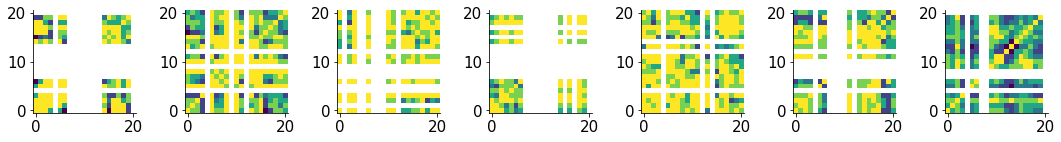

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


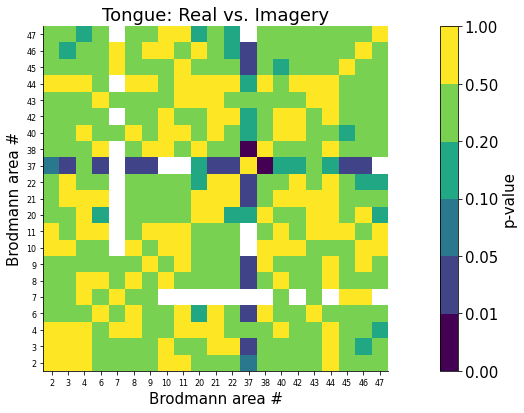

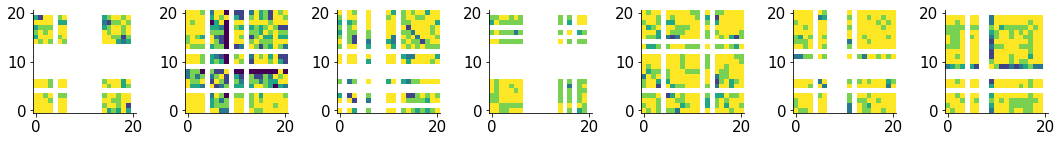

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


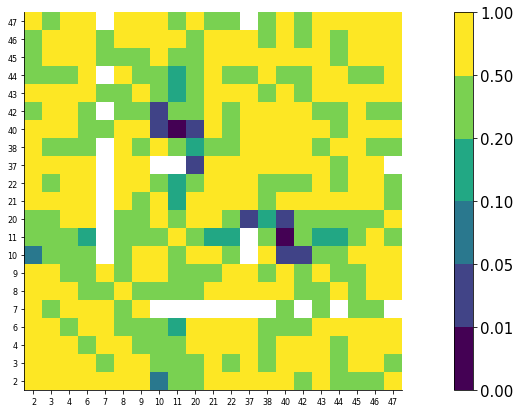

In [ ]:
from scipy.stats import stats
from scipy.stats.stats import ttest_ind_from_stats
from matplotlib import colors
corr_for_pval_mean
corr_for_pval_std

RvI = stats.ttest_ind_from_stats(corr_for_pval_mean[:, 0, :], corr_for_pval_std[:, 0, :], 30,
                                 corr_for_pval_mean[:, 1, :], corr_for_pval_std[:, 1, :], 30)

cmap = plt.get_cmap('viridis')
bounds=[0., 0.01, 0.05, 0.10, 0.20, 0.50, 1.00]
norm = colors.BoundaryNorm(bounds, cmap.N)

for s in range(7):
  plt.subplot(1, 7, s+1)
  img = plt.imshow(RvI.pvalue[s][0], interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.show()
img = plt.imshow(np.nanmean(RvI.pvalue, axis=0)[0], interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.xticks(np.arange(0, 21, 1), labels=Ba_dict, size=8)
plt.yticks(np.arange(0, 21, 1), labels=Ba_dict, size=8)
plt.title('Tongue: Real vs. Imagery')
plt.xlabel('Brodmann area #')
plt.ylabel('Brodmann area #')
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds).set_label('p-value')
plt.show()

for s in range(7):
  plt.subplot(1, 7, s+1)
  img = plt.imshow(RvI.pvalue[s][1], interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.show()
img = plt.imshow(np.nanmean(RvI.pvalue, axis=0)[1], interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.xticks(np.arange(0, 21, 1), labels=Ba_dict, size=8)
plt.yticks(np.arange(0, 21, 1), labels=Ba_dict, size=8)
plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.show()

In [ ]:
print(Ba_dict)

['2', '3', '4', '6', '7', '8', '9', '10', '11', '20', '21', '22', '37', '38', '40', '42', '43', '44', '45', '46', '47']


In [ ]:
import torch

vecarray = np.zeros((7, 2, 60, N*300))
newarray = np.zeros((7, 2*60, N*300))

print(array.shape)

for s, rvi, t in np.ndindex((7, 2, 60)):
  vecarray[s][rvi][t] = np.hstack([data_compressed[s][rvi][t][Ba] for Ba in range(N)])
print(vecarray.shape)

for s in range(7):
  newarray[s] = np.vstack([vecarray[s][rvi] for rvi in range(2)])
print(newarray.shape)

newarray_gpu = torch.from_numpy(newarray)
newarray_gpu = torch.tensor(newarray_gpu, dtype=torch.float16).cuda(0)

plt.figure(figsize=(32, 8))
for s in range(7):
  plt.subplot(2, 4, s+1)
  corr = torch.cov(newarray_gpu[s]).cpu().numpy().astype('float64')
  
  plt.imshow(corr)

(7, 2, 60, 52, 3000)
(7, 2, 60, 6300)
(7, 120, 6300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


RuntimeError: ignored

In [ ]:
corr1 = torch.corrcoef(newarray_gpu[1].T).cpu()

corr1 = np.nan_to_num(corr1.numpy().astype('float64'))
plt.imshow(corr1)
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
for s in range(7):
  plt.subplot(2, 4, s+1)
  corr = np.corrcoef(newarray[s])
  
  plt.imshow(corr)

plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(newarray[0])
#plt.plot(pca.explained_variance_ratio_, 'o')
cs = np.cumsum(pca.explained_variance_ratio_)/np.sum(pca.explained_variance_ratio_)
plt.plot(cs, 'o')
plt.axhline(y=0.9, ls='--')
print(pca.n_components_)

In [ ]:
from scipy import signal
from scipy.fft import fft

V = np.stack(df['V'].values)

print(V)

plt.imshow(V[:, :].astype('float32'), aspect='auto')

In [ ]:
fV = fft(V)
df['fV'] = [fV[i] for i in range(fV. shape[0])]
plt.imshow(fV.astype('float32'), aspect='auto')
plt.xlim(0,100)

In [ ]:
df

NameError: ignored

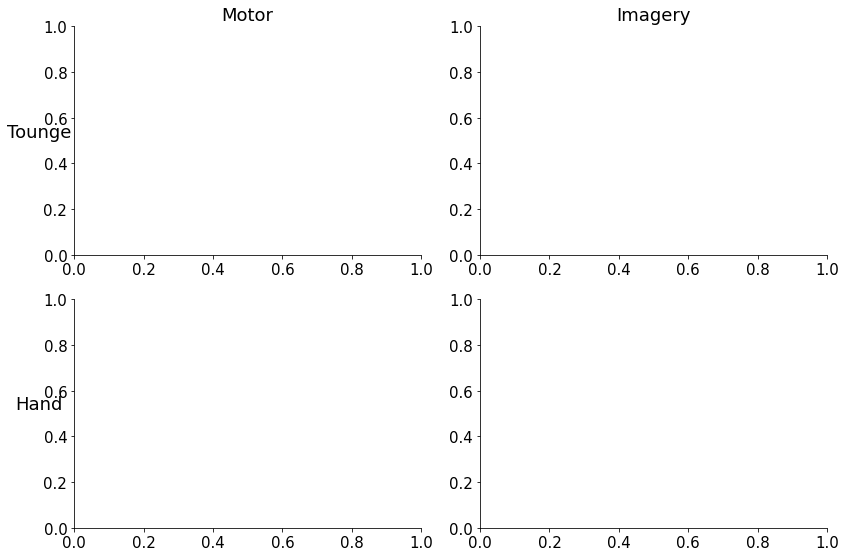

In [ ]:
cols = ['Motor', 'Imagery']
rows = ['Tounge', 'Hand']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large')

# tongue motor
t_on = alldat[0][0]['t_on']
t_off = alldat[0][0]['t_off']
trials_11 = np.zeros_like(alldat[0][0]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
trials_12 = np.zeros_like(alldat[0][0]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
for i in range(len(t_on)):
  if alldat[0][0]['stim_id'][i] == 11:
    trials_11 +=(fft(alldat[0][0]['V'][int(t_on[i]) : int(t_off[i]), :]))
  else:
    trials_12 +=(fft(alldat[0][0]['V'][int(t_on[i]) : int(t_off[i]), :]))
print(trials_11.shape)
plt.subplot(2, 2, 1)
plt.title('Motor/Tounge')
plt.ylabel('Electrode #')
plt.xlabel('Frequency(kHz)')
plt.imshow(trials_11.T.astype('float32'), aspect='auto')

# hand motor
t_on = alldat[0][0]['t_on']
t_off = alldat[0][0]['t_off']
trials_11 = np.zeros_like(alldat[0][0]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
trials_12 = np.zeros_like(alldat[0][0]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
for i in range(len(t_on)):
  if alldat[0][0]['stim_id'][i] == 11:
    trials_11 +=(fft(alldat[0][0]['V'][int(t_on[i]) : int(t_off[i]), :]))
  else:
    trials_12 +=(fft(alldat[0][0]['V'][int(t_on[i]) : int(t_off[i]), :]))
print(trials_11.shape)
plt.subplot(2, 2, 2)
plt.title('Motor/Hand')
plt.ylabel('Electrode #')
plt.xlabel('Frequency(kHz)')
plt.imshow(trials_12.T.astype('float32'), aspect='auto')

# tongue imagery
t_on = alldat[0][1]['t_on']
t_off = alldat[0][1]['t_off']
trials_11 = np.zeros_like(alldat[0][1]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
trials_12 = np.zeros_like(alldat[0][1]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
for i in range(len(t_on)):
  if alldat[0][1]['stim_id'][i] == 11:
    trials_11 +=(fft(alldat[0][1]['V'][int(t_on[i]) : int(t_off[i]), :]))
  else:
    trials_12 +=(fft(alldat[0][1]['V'][int(t_on[i]) : int(t_off[i]), :]))
print(trials_11.shape)
plt.subplot(2, 2, 3)
plt.title('Imagery/Tounge')
plt.ylabel('Electrode #')
plt.xlabel('Frequency(kHz)')
plt.imshow(trials_11.T.astype('float32'), aspect='auto')

# hand imagery
t_on = alldat[0][1]['t_on']
t_off = alldat[0][1]['t_off']
trials_11 = np.zeros_like(alldat[0][1]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
trials_12 = np.zeros_like(alldat[0][1]['V'][int(t_on[0]) : int(t_off[0]), :], dtype='complex64')
for i in range(len(t_on)):
  if alldat[0][1]['stim_id'][i] == 11:
    trials_11 +=(fft(alldat[0][1]['V'][int(t_on[i]) : int(t_off[i]), :]))
  else:
    trials_12 +=(fft(alldat[0][1]['V'][int(t_on[i]) : int(t_off[i]), :]))
print(trials_11.shape)
plt.subplot(2, 2, 4)
plt.title('Imagery/Hand')
plt.ylabel('Electrode #')
plt.xlabel('Frequency(kHz)')
plt.imshow(trials_12.T.astype('float32'), aspect='auto')

plt.show()

In [ ]:
 alldat[0][1]['V'][int(t_on[i]) : int(t_off[i]), :].shape

(3000, 46)

mean = 0.0873 std = 1.064


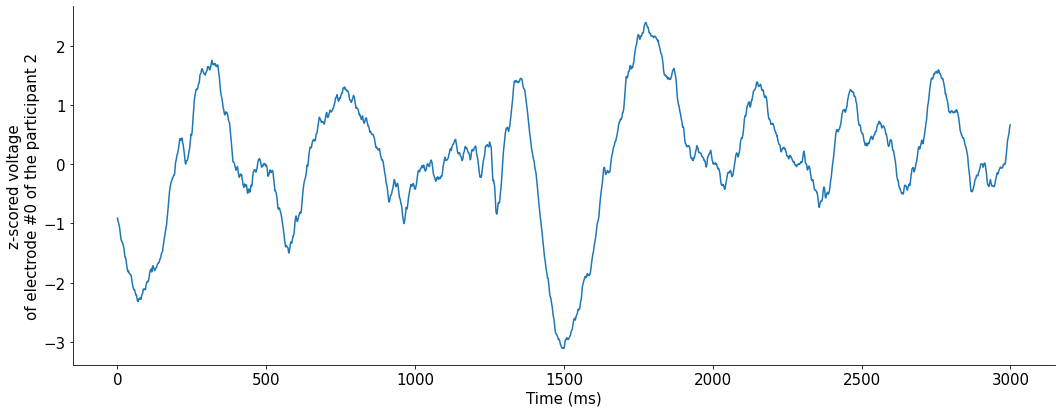

In [ ]:
rcParams['figure.figsize'] = [15, 6]
plt.xlabel('Time (ms)')
plt.ylabel('z-scored voltage\nof electrode #0 of the participant 2')
t_on = alldat[2][0]['t_on']
t_off = alldat[2][0]['t_off']
signal = alldat[2][0]['V'].T[0][t_on[3]:t_off[3]]
plt.plot(signal)
mean = np.mean(signal)
std = np.sqrt(np.mean(signal**2))
print('mean =', mean, 'std =', std)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


[0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625 0.0390625  0.04296875
 0.046875   0.05078125 0.0546875  0.05859375 0.0625     0.06640625
 0.0703125  0.07421875 0.078125   0.08203125 0.0859375  0.08984375
 0.09375    0.09765625 0.1015625  0.10546875 0.109375   0.11328125
 0.1171875  0.12109375 0.125      0.12890625 0.1328125  0.13671875
 0.140625   0.14453125 0.1484375  0.15234375 0.15625    0.16015625
 0.1640625  0.16796875 0.171875   0.17578125 0.1796875  0.18359375
 0.1875     0.19140625 0.1953125  0.19921875 0.203125   0.20703125
 0.2109375  0.21484375 0.21875    0.22265625 0.2265625  0.23046875
 0.234375   0.23828125 0.2421875  0.24609375 0.25       0.25390625
 0.2578125  0.26171875 0.265625   0.26953125 0.2734375  0.27734375
 0.28125    0.28515625 0.2890625  0.29296875 0.296875   0.30078125
 0.3046875  0.30859375 0.3125     0.31640625 0.3203125  0.32421875
 0.328125   0.33203125 0.3359375  0.33984375 0.34375    0.3476

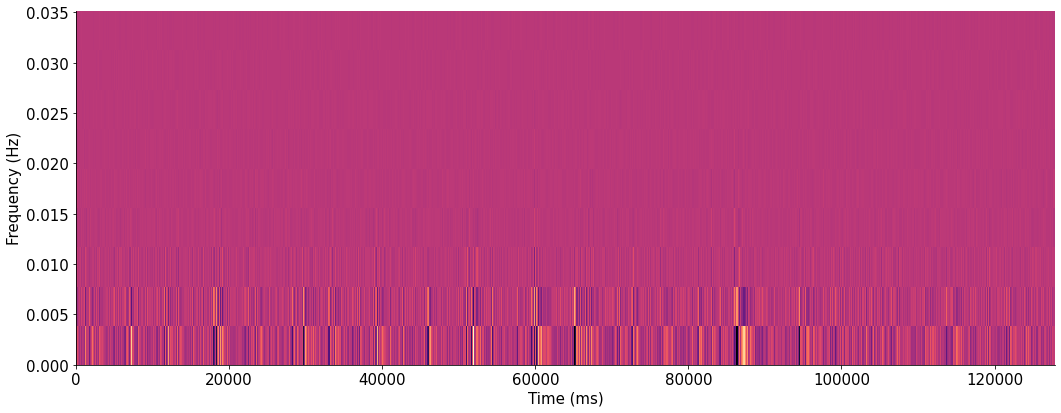

In [ ]:
from scipy import signal

f, t, zxx = signal.stft(alldat[2][0]['V'][:,0])

plt.pcolormesh(t[0:1000], f[:10], (zxx.astype('float32'))[:10, 0:1000], cmap='magma')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (ms)')
print(f)
print(t)

In [ ]:
signal.get_window(window=alldat[2][0]['t_on'], Nx=6000)

ValueError: ignored

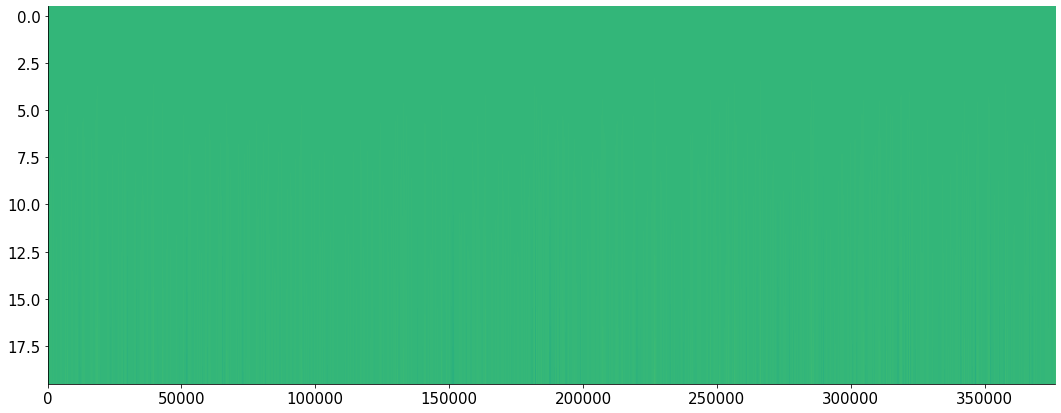

In [ ]:
cwt = signal.cwt(alldat[2][0]['V'][:,0], signal.ricker, np.arange(1, 21))

plt.imshow(cwt, aspect='auto')

Shape of the voltage recording of patient 0: (376240, 48)
(60,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


[11. 11. 11. ... 12. 12. 12.]


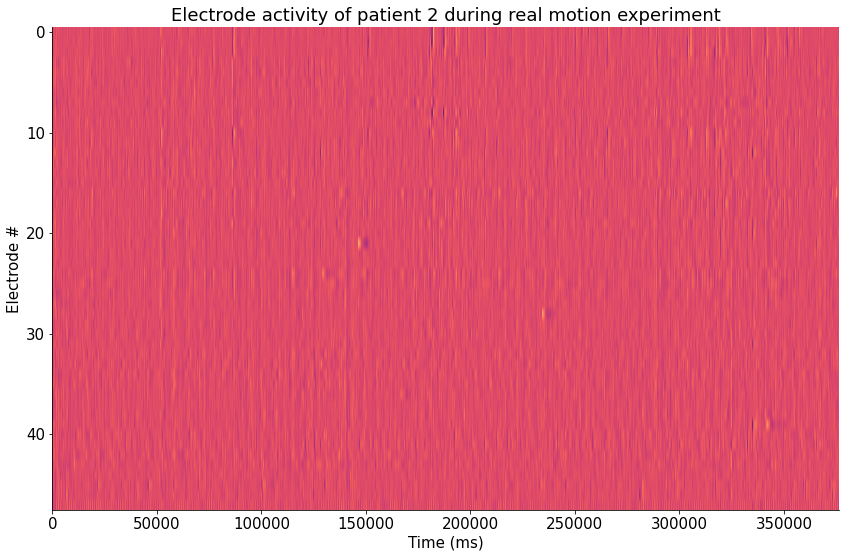

In [ ]:
rcParams['figure.figsize'] = [12, 8]

V_T = np.array(alldat[2][0]['V'], dtype='float32')
stim_id = np.array(alldat[2][0]['stim_id'], dtype='float32')
t_on = np.array(alldat[2][0]['stim_id'], dtype='float32')

print(f'Shape of the voltage recording of patient 0: {V_T.shape}')
print(stim_id.shape)
stim = np.hstack(np.hstack(np.ones(int(376600 / 60)) * s) for s in stim_id)
print(stim)
#plt.xlim(0, 200)
plt.xlabel('Time (ms)')
plt.ylabel('Electrode #')
plt.title('Electrode activity of patient 2 during real motion experiment')
plt.imshow(V_T.T, aspect='auto', cmap='magma')
#plt.plot(stim)

# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper: 

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior. 

Both experiments: 
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV). 
* `dat['locs`]`: 3D electrode positions on the brain surface

(0.0, 100000.0)

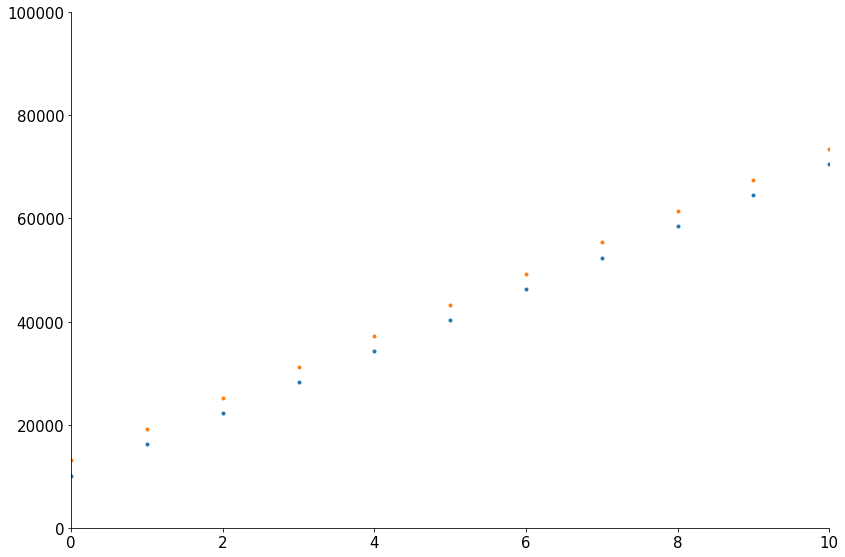

In [ ]:
plt.plot(alldat[2][0]['t_on'], '.')
plt.plot(alldat[2][0]['t_off'], '.')
plt.xlim(0, 10)
plt.ylim(0, 100000)
#plt.plot(-100000+10000*alldat[2][0]['stim_id'], 'o')

In [ ]:
trange = np.round(np.linspace(0, alldat[2][0]['V'].shape[0], alldat[2][0]['V'].shape[0]+1))
n = alldat[2][0]['t_on'].shape[0]
t_on = alldat[2][0]['t_on']
t_off = alldat[2][0]['t_off']
t = np.random.choice(trange)

print(any([t_on[i] < t < t_off[i] for i in range(n)]))

on = np.zeros_like(trange)
for j, t in enumerate(trange):
  if any([t_on[i] < t < t_off[i] for i in range(n)]):
    on[j] = 1

39541.0
False


(0.0, 40000.0)

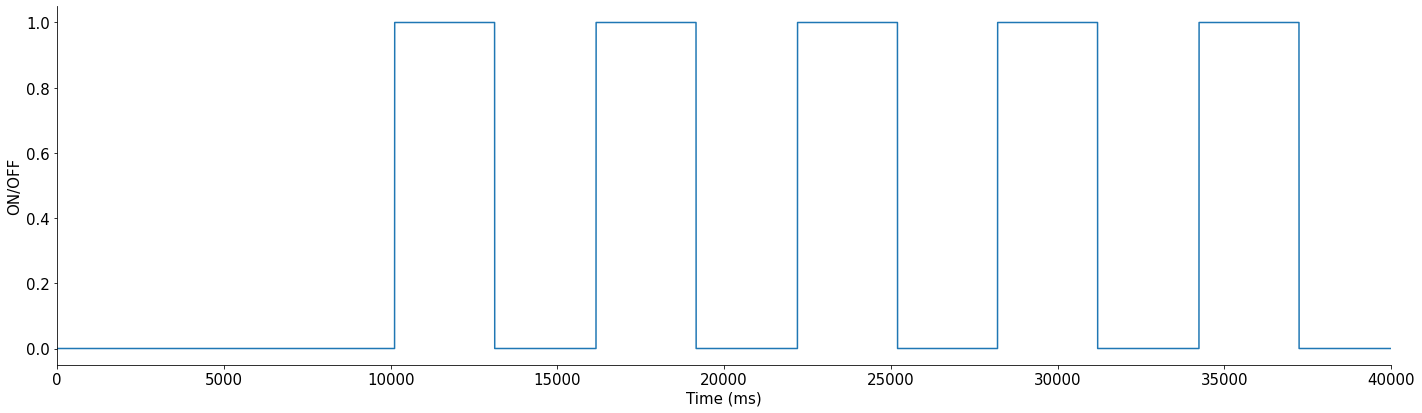

In [ ]:
rcParams['figure.figsize'] = [20, 6]
plt.plot(trange, on)
plt.xlabel('Time (ms)')
plt.ylabel('ON/OFF')
plt.xlim(0, 40000)

In [ ]:
np.diff(alldat[2][0]['t_on'])

array([6040, 6040, 6000, 6040, 6040, 6040, 6040, 6080, 6040, 6040, 6000,
       6040, 6000, 6000, 6080, 6000, 6080, 6040, 6080, 6080, 6080, 6080,
       6000, 6000, 6040, 6040, 6000, 6040, 6040, 6040, 6080, 6080, 6040,
       6080, 6000, 6000, 6000, 6080, 6080, 6000, 6000, 6000, 6080, 6000,
       6080, 6040, 6000, 6040, 6040, 6040, 6000, 6000, 6080, 6040, 6040,
       6040, 6000, 6040, 6000])

In [ ]:
alldat[2][0]['t_off'] - alldat[2][0]['t_on']

array([3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
       3000, 3000, 3000, 3000, 3000])

In [ ]:
alldat[2][0]['scale_uv'].shape

(48,)

In [ ]:
alldat[2][0]['locs'].shape

(48, 3)

In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 576x576 with 0 Axes>

In [ ]:
# quick way to get broadband power in time-varying windows
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [ ]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

In [ ]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
plt.show()

In [ ]:
# let's look at all the trials for electrode 20 that has a good response to hand movements
# we will sort trials by stimulus id
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 20].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

In [ ]:
# Electrode 42 seems to respond to tongue movements
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 35].astype('float32'),
           aspect='auto',
           vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()